## Australian Broadcasting Corporation iview show recommendations

Utrecht University, Applied Data Science, Personalisation for (public) media, assignment 2

By Liesje Bloembergen (...), Nelly Dua (...), Sander Engelberts (1422138), Bruno Laiber De Pinho (1450506), and Jo Schreurs (1774832)

March-April 2022

In [1]:
# Import all required packages
import os # directory paths
import pandas as pd # DataFrames
import pickle # Pickle file
from tqdm.auto import tqdm # Progress monitoring

# Extracting information from .html pages
import glob
from bs4 import BeautifulSoup

# Visualisation
import matplotlib.pyplot as plt
import numpy as np

# Text processing
import re
import spacy
from sklearn.feature_extraction import text

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering and distance metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import linear_kernel

# Visualise clusters in 2D
from sklearn.decomposition import PCA
from scipy.sparse import dok_matrix

# Word embeddings
import gensim
from gensim.models import Word2Vec

### Retrieve meta data of scraped .html webpages

In [2]:
def get_immediate_subdirectories(a_dir):
    """
    Retrieves names of folders within a given directory
    
    Parameters
    ----------
    a_dir : str
        Path to a directory for which to check the subfolder names
    
    Returns
    -------
    subfolder_names : list of str
        List with names of subfolders within a_dir
    """
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [3]:
# Path to folder with data (.html pages of shows on ABC iview)
# 'ABC_shows' is the data that is not enriched with episodes
folder_path = os.path.join(os.getcwd(), 'ABC_with_episodes')

# Retrieve the subfolder names, which correspond to genres
folders = get_immediate_subdirectories(folder_path)

In [4]:
# Display genre names
folders

['arts',
 'comedy',
 'documentary',
 'drama',
 'education',
 'family',
 'kids',
 'lifestyle',
 'movies',
 'news',
 'panel-discussion']

In [5]:
# Retrieve meta data from each scraped file and save in data list (separate for shows and episodes)
# In specific retrieve the show title, its description, genre name, website url, url to image,
# and file name. The latter will be used to make sure duplicate files will be merged into one item
# with all genre names concatenated
# Make sure that this file is not running in a too deep folder structure, because then some
# file names are too long and hence may throuw a FileNotFoundError even though it does exist
show_data = []
episode_data = []

# Loop through all genre folders 
for folder in tqdm(folders, total = len(folders)):

    # Retrieve file names of .html files from current subfolder location 
    files = glob.glob(os.path.join(folder_path, folder, '*.html'))

    # Loop through all files of this genre
    for file in tqdm(files, total = len(files)):
        with open(file, 'rb') as f:
            # Parse the opened file
            soup = BeautifulSoup(f, 'html.parser')

            # Retrieve .html file name which is used to later check if this file
            # is also contained in a different genre folder, to then merge those items
            # File name is the last element of the file path when it is split up into
            # its separate components (genre name thus is the one to last item as it is
            # the subfolder name)
            file_split = file.split(os.sep)
            file_name = file_split[-1]
            
            # The first part of the file name is 'show' or 'video', split by '-',
            # depending on if respectively the general page of a show is displayed 
            # in the .html page or an episode of one
            show_episode_tag = file_name.split('-')[0]
            is_show = show_episode_tag == 'show' # True if this is a show, else an episode

            # Retrieve genre from the subfolder name the file is in 
            # (organized like that while scraping). This additional information
            # is only needed for shows (episodes will link to there anyways)
            if is_show:
                genre = folder
            
            # Extract data from .html page itself, using try-except clauses for if 
            # the data is None (if so, just set the variable as empty string).
            # This retrieval is the same for shows as for episodes, where episodes
            # just display different content
            # Retrieve show title (for episodes this also contains season/episode number)
            try:
                title = soup.find('meta',  attrs={'property': 'og:title'})['content']
            except:
                title = ''

            # Retrieve show description
            try:
                description = soup.find('meta',  attrs={'property': 'og:description'})['content'] 
            except:
                description = ''

            # Retrieve url of webpage on ABC iview this .html file got scraped from
            try:
                website_url = soup.find('meta',  attrs={'property': 'og:url'})['content']
            except:
                website_url = ''

            # Retrieve url to image of the show/episode
            try:
                image_url = soup.find('meta',  attrs={'property': 'og:image'})['content'] 
            except:
                image_url = ''
                
            # In case of episodes, also retrieve the show name, which can be found under
            # the title tag instead of og:title. This will be used to uniquely match 
            # episodes with their shows
            if not is_show:
                try:
                    show_title = soup.find('meta',  attrs={'name':'title'})['content']
                except:
                    show_title = ''

            # Add information of this show/episode to the respective data list
            if is_show:
                show_data.append([title, description, genre, website_url, image_url, file_name])
            else:
                episode_data.append([show_title, title, description, website_url, 
                                     image_url, file_name])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/1296 [00:00<?, ?it/s]

  0%|          | 0/1122 [00:00<?, ?it/s]

  0%|          | 0/1175 [00:00<?, ?it/s]

  0%|          | 0/2529 [00:00<?, ?it/s]

  0%|          | 0/2056 [00:00<?, ?it/s]

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/1173 [00:00<?, ?it/s]

  0%|          | 0/477 [00:00<?, ?it/s]

In [6]:
# Convert list with show information to pandas dataframe and inspect it
df_data = pd.DataFrame(show_data, columns=['title', 'description', 'genre', 'website_url', 
                                      'image_url', 'file_name'])
df_data.head()

title                                        description  \
0           And We Danced  The Australian Ballet has evolved to become ou...   
1   Anh's Brush With Fame  Anh Do paints some of Australia's most famous ...   
2    The Art Of Australia  The Art of Australia explores how art and arti...   
3   The Art of Collecting  These short intimate stories by artist Kate Bl...   
4  The Art of Remembrance  Nate Byrne explores the role of paintings and ...   

  genre                                        website_url  \
0  arts        https://iview.abc.net.au/show/and-we-danced   
1  arts  https://iview.abc.net.au/show/anh-s-brush-with...   
2  arts     https://iview.abc.net.au/show/art-of-australia   
3  arts  https://iview.abc.net.au/show/art-of-collectin...   
4  arts  https://iview.abc.net.au/show/art-of-remembran...   

                                           image_url  \
0  https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...   
1  https://cdn.iview.abc.net.au/thumbs/i/do/DO203...   
2  https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...   
3  https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...   
4  https://cdn.iview.abc.net.au/thumbs/i/rf/RF200...   

                                          file_name  
0                           show-and-we-danced.html  
1                   show-anh-s-brush-with-fame.html  
2                        show-art-of-australia.html  
3   show-art-of-collecting-video-AC1940H006S00.html  
4  show-art-of-remembrance-video-RF2009H001S00.html

In [7]:
# Convert list with episode information to pandas dataframe and inspect it
df_episodes = pd.DataFrame(episode_data, columns=['show_title', 'episode_title', 'description', 
                                                  'website_url', 'image_url', 'file_name'])
df_episodes.head()

show_title                                      episode_title  \
0    Hannah Gadsby's OZ                      Hannah Gadsby's OZ: Episode 1   
1    Hannah Gadsby's OZ                      Hannah Gadsby's OZ: Episode 2   
2    Hannah Gadsby's OZ                      Hannah Gadsby's OZ: Episode 3   
3  The Art Of Australia  The Art Of Australia: Series 1 Strangers In A ...   
4  The Art Of Australia       The Art Of Australia: Series 1 Coming Of Age   

                                         description  \
0  Through a re-examining of colonial era paintin...   
1  If the Australian art cannon is to be believed...   
2  Hannah is still searching for a more inclusive...   
3  The story of how art helped European settlers ...   
4  Edmund explores how Australian identity evolve...   

                                         website_url  \
0  https://iview.abc.net.au/show/hannah-gadsby-s-...   
1  https://iview.abc.net.au/show/hannah-gadsby-s-...   
2  https://iview.abc.net.au/show/hannah-gadsby-s-...   
3  https://iview.abc.net.au/show/art-of-australia...   
4  https://iview.abc.net.au/show/art-of-australia...   

                                           image_url                 file_name  
0  https://cdn.iview.abc.net.au/thumbs/i/ac/AC111...  video-AC1111S001S00.html  
1  https://cdn.iview.abc.net.au/thumbs/i/ac/AC111...  video-AC1111S002S00.html  
2  https://cdn.iview.abc.net.au/thumbs/i/ac/AC111...  video-AC1111S003S00.html  
3  https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...  video-AC1230H001S00.html  
4  https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...  video-AC1230H002S00.html

In [8]:
# Change all values in the dataframe to strings
# There previously could be some objects encoded as floats, while
# strings are required for further processing
df_data = df_data.astype('str')
df_episodes = df_episodes.astype('str')

In [9]:
# Save the raw data with information about shows/episodes to disk
df_data.to_csv(os.path.join(folder_path, 'raw_data.csv'), index=False, sep=',')
df_episodes.to_csv(os.path.join(folder_path, 'raw_episode_data.csv'), index=False, sep=',')

### Check data completeness

In [10]:
# Only keep the shows that contain a description (which are needed for content based comparisons)
n_shows_original = len(df_data)
df_data = df_data[df_data.description != '']
n_shows_description = len(df_data)
print('There are ', n_shows_original, ' shows in the raw data, and ', n_shows_description, 
      ' shows when shows without description are removed')

There are  1350  shows in the raw data, and  1348  shows when shows without description are removed


In [11]:
# Only keep the shows that contain a title, genre, and image link (needed for visualisation purposes in interface)
df_data = df_data[(df_data.title != '') & (df_data.genre != '') & (df_data.image_url != '')]
print('There are ', len(df_data), 
      ' shows when shows without title, genre and image url are also are removed')

There are  1348  shows when shows without title, genre and image url are also are removed


In [12]:
# Only keep episodes that contain a show_title (the rest could be set identical from show itself)
n_episodes_original = len(df_episodes)
df_episodes = df_episodes[df_episodes.show_title != '']
print('There are ', len(df_episodes), ' of the original ', n_episodes_original, 
      ' episodes when ones without reference to show title are removed')

There are  14548  of the original  14550  episodes when ones without reference to show title are removed


### Create nicer genre names

In [13]:
# Get the current genre names which are used in the subfolder names of .html files,
# which we want to replace by capitalised versions without dashes in between them for 
# visualisation purposes in the interface
old_genre_names = df_data.genre.unique()
print(old_genre_names)

['arts' 'comedy' 'documentary' 'drama' 'education' 'family' 'kids'
 'lifestyle' 'news' 'panel-discussion']


In [14]:
# In the same order as the old_genre_names specify the strings to replace these with
# Movies is a genre of original show data, but not in the data that also includes episodes
new_genre_names = ['Arts and culture', 'Comedy', 'Documentary', 'Drama', 'Education', 
                   'Family', 'Kids', 'Lifestyle', 'News and current affairs', 
                   'Panel and discussion'] 

In [15]:
# Replace old genre strings for new ones
df_data['genre'] = df_data['genre'].replace(old_genre_names, new_genre_names)

In [16]:
# Inspect dataframe with new genre names
df_data.head()

title                                        description  \
0           And We Danced  The Australian Ballet has evolved to become ou...   
1   Anh's Brush With Fame  Anh Do paints some of Australia's most famous ...   
2    The Art Of Australia  The Art of Australia explores how art and arti...   
3   The Art of Collecting  These short intimate stories by artist Kate Bl...   
4  The Art of Remembrance  Nate Byrne explores the role of paintings and ...   

              genre                                        website_url  \
0  Arts and culture        https://iview.abc.net.au/show/and-we-danced   
1  Arts and culture  https://iview.abc.net.au/show/anh-s-brush-with...   
2  Arts and culture     https://iview.abc.net.au/show/art-of-australia   
3  Arts and culture  https://iview.abc.net.au/show/art-of-collectin...   
4  Arts and culture  https://iview.abc.net.au/show/art-of-remembran...   

                                           image_url  \
0  https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...   
1  https://cdn.iview.abc.net.au/thumbs/i/do/DO203...   
2  https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...   
3  https://cdn.iview.abc.net.au/thumbs/i/ac/AC194...   
4  https://cdn.iview.abc.net.au/thumbs/i/rf/RF200...   

                                          file_name  
0                           show-and-we-danced.html  
1                   show-anh-s-brush-with-fame.html  
2                        show-art-of-australia.html  
3   show-art-of-collecting-video-AC1940H006S00.html  
4  show-art-of-remembrance-video-RF2009H001S00.html

### Non-cleaned data exploration

In [17]:
# Create column with show description length (in word count)
df_data['description_length'] = df_data.description.apply(lambda x: x[1:-1].split(' '))
df_data['description_length'] = df_data.description_length.apply(len)

In [18]:
def description_length_statistics(df, description_length_col='description_length'):
    """
    Determines description length statistics and visually plots the
    length distribution over all texts in the given data
    
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame containing a column called 'description_length'
        containing integer values of description lengths
    description_length_col : str (default 'description_length')
        String indicating the column name with description length
        values to determine statistics for
    """
    # Determine description length statistics
    min_descr_len = df[description_length_col].min()
    max_descr_len = df[description_length_col].max()
    mean_descr_len = df[description_length_col].mean()
    median_descr_len = df[description_length_col].median()

    print("Minimum description length is: ", min_descr_len, " words")
    print("Maximum description length is: ", max_descr_len, " words")
    print("Mean description length is: ", "{:.0f}".format(mean_descr_len), " words")
    print("Median description length is: ", "{:.0f}".format(median_descr_len), " words")
    
    # Plot distribution of description length  
    # Most descriptions are in the range mean description length +- 10 words (no long tails)
    # Because enriched description data is much longer, the xticks have different step sizes
    df[description_length_col].plot.kde()
    if max_descr_len < 100:
        step = 5
    elif max_descr_len < 2000:
        step = 100
    else:
        step = 250
    plt.xticks(np.arange(0, max_descr_len+1, step), rotation=45)
    plt.xlim(xmax = max_descr_len+step, xmin = min_descr_len-step)
    plt.xlabel("Number of words in description")
    plt.title("Distribution of description lengths")
    plt.show()

Minimum description length is:  5  words
Maximum description length is:  52  words
Mean description length is:  31  words
Median description length is:  32  words


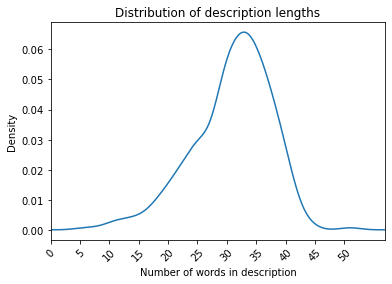

In [19]:
# Determine description length statistics for the full, uncleaned data,
# which has not been enriched with data about show episodes
description_length_statistics(df=df_data)

In [20]:
def genre_statistics(df):
    """
    Determines genre statistics and visually plots the
    genre distribution over all shows in the given data
    
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame containing a column called 'genre'
        containing string values of genre names
    """
    # Check distribution of number of shows per genre (combination)
    genre_counts = df.genre.value_counts()
    genre_frequencies = df.genre.value_counts(normalize=True)
    genre_count_freq = pd.concat([genre_counts, genre_frequencies], axis=1, 
                                 keys=['count', 'frequency'])
    
    # Display genre distribution in a table
    display(genre_count_freq)
    
    # Make visualisation of the distribution of shows (with description length > 20 words) over genres
    genre_counts.plot.bar()
    plt.title('Number of ABC shows per genre')
    plt.ylabel('Number of ABC shows')
    plt.xlabel('ABC show genre')
    plt.show()

count  frequency
Drama                       226   0.167656
Documentary                 206   0.152819
Kids                        177   0.131306
Education                   171   0.126855
Family                      159   0.117953
Comedy                      111   0.082344
Arts and culture            109   0.080861
News and current affairs    101   0.074926
Lifestyle                    48   0.035608
Panel and discussion         40   0.029674

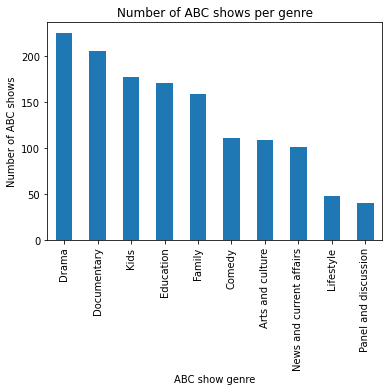

In [21]:
# Determine genre statistics for the full, uncleaned data (so duplicates exists due
# to shows belonging to multiple genres), which has not been enriched with data 
# about show episodes
genre_statistics(df=df_data)

In [22]:
def genre_description_statistics(df, description_length_col='description_length'):
    """
    Determines interrelation of genre and description length statistics 
    for all shows in the given data and displays this in a table 
    
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame containing columns called 'genre'
        containing string values of genre names and
        'description_length' containing integer values 
        of description lengths
    description_length_col : str (default 'description_length')
        String indicating the column name with description length
        values to determine statistics for
    """
    # Check description length statistics distribution over genres 
    # (of shows with description length > 20 words)
    grouped_genre = df.groupby('genre')
    genre_min_length = grouped_genre[description_length_col].min('min')
    genre_max_length = grouped_genre[description_length_col].max('max')
    genre_mean_length = grouped_genre[description_length_col].mean('mean')
    genre_median_length = grouped_genre[description_length_col].median('median')
    
    # Concatenate all statistics into one dataframe and inspect it
    genre_length_stat = pd.concat([genre_min_length, genre_max_length, genre_mean_length, 
                                   genre_median_length], axis=1, 
                                  keys=['min', 'max', 'mean', 'median'])
    display(genre_length_stat)

In [23]:
# Determine description length statistics for separate genres for the full, 
# uncleaned data (so duplicates exists due to shows belonging to multiple genres), 
# which has not been enriched with data about show episodes
genre_description_statistics(df=df_data)

min  max       mean  median
genre                                                
Arts and culture           12   42  30.422018    31.0
Comedy                     17   43  30.612613    31.0
Documentary                11   52  30.800971    32.0
Drama                      13   42  30.924779    31.0
Education                   7   51  30.573099    32.0
Family                      5   44  31.283019    33.0
Kids                        5   51  31.084746    32.0
Lifestyle                  15   40  30.041667    31.0
News and current affairs    9   42  31.821782    34.0
Panel and discussion        9   42  31.125000    32.5

### Clean data from duplicates

In [24]:
# Make sure shows that are duplicated in the dataframe due to belonging to multiple
# genres (so being in multiple different subfolders) are merged into one show item 
# (with concatenated genre names). These shows have the exact same file name so
# there will be checked on that basis. Still, there may be some shows remaining that seem
# the same, but are then actually different webpages due to being some newer edition,
# having specific language subtitles, or due to other reasons. 

# Group by file name to get duplicates in same group
df_duplicates_group = df_data.groupby(by='file_name') 

# Get the filenames of unique shows (which are keys to retrieve information of its group with)
unique_file_names = df_duplicates_group.groups.keys() 

unique_shows = []

# Loop through unique filenames and merge duplicates
for show_name in tqdm(unique_file_names, total=len(unique_file_names)):
    # Retrieve the group with possible duplicates of this file name
    show_group = df_duplicates_group.get_group(show_name) 
    
    # Get items of first show in the group (for which description etc. are equal)
    info_group = show_group.head(1)
    
    # Check the number of shows with this same file name, and depending on that
    # need to concatenate genre names of items in this group or not
    n_shows_in_group = len(show_group) 
    if n_shows_in_group > 1:
        # Merge the duplicate shows information by appending the genre labels.
        # The rest of the elements is equal (e.g. description, title) as these were
        # based on their webpage contents (which is equal) whereas the genre name 
        # was based on the folder to which the .html file was scraped.
        # Add all genre names to one string and separate by commas
        genre_str = ', '.join(show_group.genre)
    else:
        # Just get the genre from the first show as there are no duplicates.
        # Here and for the other information use .iloc[0] because a pandas series with 
        # information is returned and not the raw string with information
        genre_str = info_group.genre.iloc[0]
    
    # Add information of single show (without its possible duplicates) to list    
    unique_shows.append([info_group.title.iloc[0], info_group.description.iloc[0], 
                         genre_str, info_group.website_url.iloc[0], info_group.image_url.iloc[0], 
                         info_group.description_length.iloc[0]])

  0%|          | 0/1090 [00:00<?, ?it/s]

In [25]:
n_before_dupl = len(df_data) # Check number of shows before duplication removal

In [26]:
# Convert data with duplicate shows removed to a DataFrame again and inspect it
df_data = pd.DataFrame(unique_shows, columns=['title', 'description', 'genre', 
                                               'website_url', 'image_url', 'description_length'])
df_data.head()

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36  
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38  
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45  
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39  
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13

In [27]:
# Check how many duplicate shows were removed due to belonging to multiple genres
n_after_dupl = len(df_data) 
print('There are ', (n_before_dupl - n_after_dupl), 
      ' show items removed due to being duplicates, so ', n_after_dupl, 
      ' of ', n_before_dupl, 'shows are left in the data')

There are  258  show items removed due to being duplicates, so  1090  of  1348 shows are left in the data


In [28]:
# Remove duplicate episodes, which is also due to shows belonging to multiple genres
# so files being duplicated into multiple genre folders. Here is no need to merge any 
# information because genres are already merged in show data, so just keep first instance.
# Because the files of duplicates are exactly the same, all columns will be used for checking
# which rows are duplicates (i.e. subset=None)
df_episodes.drop_duplicates(subset=None, keep='first', inplace=True)

In [29]:
print('There are ', len(df_episodes), 
      ' episodes left after removing duplicates')

There are  11704  episodes left after removing duplicates


### Non-cleaned episode exploration

In [30]:
# Check the number of shows that contain episodes
episodes_per_show = df_episodes.groupby('show_title')
n_shows_with_episodes = len(episodes_per_show)

print("There are ", n_shows_with_episodes, " shows that contain episodes")

There are  836  shows that contain episodes


Minimum number of episodes per serie is:  1
Maximum number of episodes per serie is:  149
Mean number of episodes per serie is:  14
Median number of episodes per serie is:  6


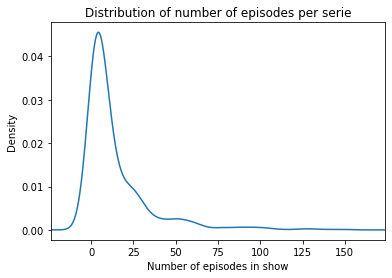

In [31]:
# Show number of episodes per serie statistics
count_episodes_per_show = episodes_per_show.count()['episode_title'] 

min_episodes = count_episodes_per_show.min()
max_episodes = count_episodes_per_show.max()
mean_episodes = count_episodes_per_show.mean()
median_episodes = count_episodes_per_show.median()

print("Minimum number of episodes per serie is: ", min_episodes)
print("Maximum number of episodes per serie is: ", max_episodes)
print("Mean number of episodes per serie is: ", "{:.0f}".format(mean_episodes))
print("Median number of episodes per serie is: ", "{:.0f}".format(median_episodes))
    
# Plot number of episodes per show that contains episodes
count_episodes_per_show.plot.kde()
plt.xlim(min_episodes-25, max_episodes+25)
plt.xlabel("Number of episodes in show")
plt.title("Distribution of number of episodes per serie")
plt.show()

In [32]:
# Create column with episode description length (in word count)
df_episodes['description_length'] = df_episodes.description.apply(lambda x: x[1:-1].split(' '))
df_episodes['description_length'] = df_episodes.description_length.apply(len)

Minimum description length is:  3  words
Maximum description length is:  78  words
Mean description length is:  29  words
Median description length is:  30  words


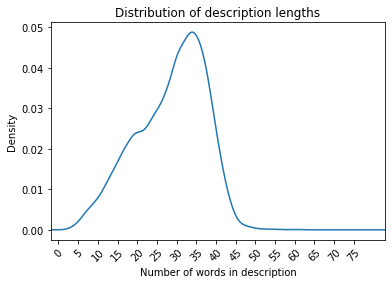

In [33]:
# Determine description length statistics for the full, uncleaned episode data,
# which has only dropped duplicates
description_length_statistics(df=df_episodes)

### Episode matching to shows

In [34]:
# Reindex df_data and add a column with unique id for each show,
# which will be used to uniquely refer to a specific show
# This is also used to link from episodes to their respective shows.
# After this linking there may still be some shows removed due to too
# short descriptions for accurate modelling, so gaps in the id may occur 
# in the fully cleaned data
df_data = df_data.reset_index(drop=True)
df_data['id'] = range(len(df_data))

In [35]:
df_data.head()

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  id  
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0  
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1  
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2  
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3  
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4

In [36]:
# Link each episode to their corresponding show with the id that is set for each show above.
# Because some shows may be removed due to having incomplete data, it may be the case
# that an episode doesn't have a show anymore or that the show title can't uniquely
# refer to a show, and then no show id can be added 
show_ids = []
for i, episode in tqdm(df_episodes.iterrows(), total=len(df_episodes)):
    show = df_data[df_data['title'] == episode['show_title']]
    # Append show id when this could be retrieved above, else fill in NaN
    if not show.empty:
        show_id = show['id']
        show_ids.append(show_id.values[0]) # Get id value from Pandas Series object
    else:
        show_ids.append('NaN')

  0%|          | 0/11704 [00:00<?, ?it/s]

In [37]:
# Add show_ids to episode dataframe and inspect it
df_episodes['show_id'] = show_ids
df_episodes.head()

show_title                                      episode_title  \
0    Hannah Gadsby's OZ                      Hannah Gadsby's OZ: Episode 1   
1    Hannah Gadsby's OZ                      Hannah Gadsby's OZ: Episode 2   
2    Hannah Gadsby's OZ                      Hannah Gadsby's OZ: Episode 3   
3  The Art Of Australia  The Art Of Australia: Series 1 Strangers In A ...   
4  The Art Of Australia       The Art Of Australia: Series 1 Coming Of Age   

                                         description  \
0  Through a re-examining of colonial era paintin...   
1  If the Australian art cannon is to be believed...   
2  Hannah is still searching for a more inclusive...   
3  The story of how art helped European settlers ...   
4  Edmund explores how Australian identity evolve...   

                                         website_url  \
0  https://iview.abc.net.au/show/hannah-gadsby-s-...   
1  https://iview.abc.net.au/show/hannah-gadsby-s-...   
2  https://iview.abc.net.au/show/hannah-gadsby-s-...   
3  https://iview.abc.net.au/show/art-of-australia...   
4  https://iview.abc.net.au/show/art-of-australia...   

                                           image_url  \
0  https://cdn.iview.abc.net.au/thumbs/i/ac/AC111...   
1  https://cdn.iview.abc.net.au/thumbs/i/ac/AC111...   
2  https://cdn.iview.abc.net.au/thumbs/i/ac/AC111...   
3  https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...   
4  https://cdn.iview.abc.net.au/thumbs/i/ac/AC123...   

                  file_name  description_length show_id  
0  video-AC1111S001S00.html                  25     421  
1  video-AC1111S002S00.html                  39     421  
2  video-AC1111S003S00.html                  33     421  
3  video-AC1230H001S00.html                  33      68  
4  video-AC1230H002S00.html                  39      68

In [38]:
# Remove episodes of which no show exists (anymore) or which couldn't uniquely refer to a show
remove_episodes = df_episodes[df_episodes.show_id == 'NaN']
print("The number of episodes that couldn't uniquely refer to a show is: ", 
      len(remove_episodes))

df_episodes.drop(remove_episodes.index, axis='index', inplace=True)

print("Check that all episodes now indeed refer to a show: ", 
      len(df_episodes[df_episodes.show_id == 'NaN']) == 0)

The number of episodes that couldn't uniquely refer to a show is:  47
Check that all episodes now indeed refer to a show:  True


### Enriching show description data with episode descriptions

In [39]:
# Enrich the short show descriptions with the descriptions of their episodes 
# (in case the show contains episodes) when these episode descriptions are not equal
# to the show description. This way there is more information available about a show,
# so better inferences can be made about similarities between shows. 
enriched_descriptions = []
for i, show in tqdm(df_data.iterrows(), total=len(df_data)):
    # Shows that don't contain episodes will just keep their original description
    show_description = show['description']
    enriched_description = show_description
    
    # Retrieve the episodes beloging to this show
    show_episodes = df_episodes[df_episodes.show_id == show.id]
    
    # Add each episode description to enriched_description
    # if this one is not the same as the original show description
    # (in case the show doesn't contain episodes, it will skip this loop)
    for j, episode in show_episodes.iterrows():
        episode_description = episode['description']
        if episode_description != show_description:
            enriched_description += ' ' + episode_description
            
    # Add enriched description to list
    enriched_descriptions.append(enriched_description)

  0%|          | 0/1090 [00:00<?, ?it/s]

In [40]:
# Add enriched descriptions to show dataset, determine their word counts, and inspect it
df_data['enriched_description'] = enriched_descriptions
df_data['enriched_description_length'] = df_data.enriched_description.apply(lambda x: x[1:-1].split(' '))
df_data['enriched_description_length'] = df_data.enriched_description_length.apply(len)
df_data.head()

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  id  \
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0   
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1   
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2   
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3   
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4   

                                enriched_description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

   enriched_description_length  
0                           36  
1                           38  
2                          856  
3                           39  
4                          456

### Enriched data exploration

Minimum description length is:  8  words
Maximum description length is:  4737  words
Mean description length is:  324  words
Median description length is:  131  words


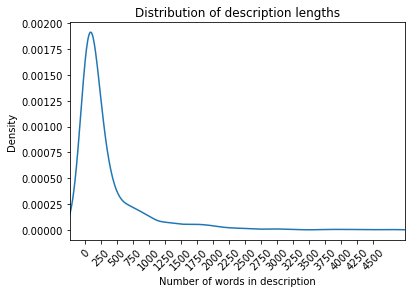

In [41]:
# Determine description length statistics for the enriched data,
# which has been enriched with data about show episodes
description_length_statistics(df=df_data, description_length_col='enriched_description_length')

count  frequency
Drama                                               200   0.183486
Kids                                                134   0.122936
Education                                           122   0.111927
Documentary                                          99   0.090826
Family                                               75   0.068807
News and current affairs                             72   0.066055
Comedy                                               70   0.064220
Arts and culture                                     50   0.045872
Documentary, Family                                  39   0.035780
Arts and culture, Documentary                        28   0.025688
Education, Kids                                      25   0.022936
Comedy, Drama                                        23   0.021101
Lifestyle                                            23   0.021101
Family, Kids                                         18   0.016514
News and current affairs, Panel and discussion       18   0.016514
Documentary, Lifestyle                               14   0.012844
Education, Family                                    10   0.009174
Panel and discussion                                  9   0.008257
Comedy, Panel and discussion                          8   0.007339
Arts and culture, Documentary, Lifestyle              6   0.005505
Arts and culture, Education                           5   0.004587
Documentary, News and current affairs                 5   0.004587
Arts and culture, Family                              5   0.004587
Arts and culture, Panel and discussion                3   0.002752
Documentary, Education, Family                        3   0.002752
Education, News and current affairs                   3   0.002752
Arts and culture, Comedy                              2   0.001835
Arts and culture, Comedy, Documentary                 2   0.001835
Comedy, Family                                        2   0.001835
Documentary, Family, Lifestyle                        2   0.001835
Arts and culture, Documentary, Family                 2   0.001835
Family, Lifestyle                                     2   0.001835
Comedy, Documentary                                   1   0.000917
Arts and culture, Comedy, Documentary, Drama          1   0.000917
Arts and culture, Lifestyle                           1   0.000917
Arts and culture, Drama                               1   0.000917
Arts and culture, Comedy, Panel and discussion        1   0.000917
Comedy, Education, News and current affairs           1   0.000917
Documentary, Drama                                    1   0.000917
Arts and culture, Documentary, Education, Family      1   0.000917
Documentary, Education, News and current affairs      1   0.000917
Arts and culture, News and current affairs            1   0.000917
Documentary, Panel and discussion                     1   0.000917

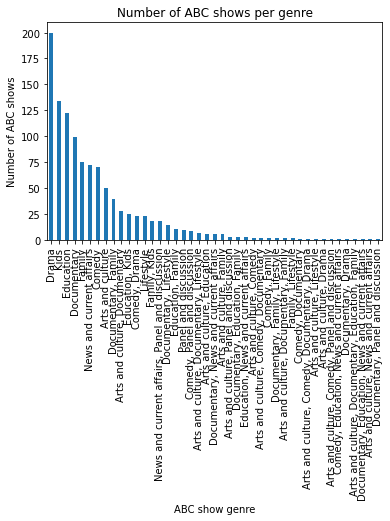

In [42]:
# Determine genre statistics for the enriched data (duplicates are removed due
# to shows belonging to multiple genres), which has been enriched with data 
# about show episodes
genre_statistics(df=df_data)

In [43]:
# Determine description length statistics for separate genres for the enriched 
# data (duplicates are removed due to shows belonging to multiple genres), 
# which has been enriched with data about show episodes
genre_description_statistics(df=df_data, description_length_col='enriched_description_length')

min   max         mean  \
genre                                                                       
Arts and culture                                    12  2478   180.980000   
Arts and culture, Comedy                            30  1264   647.000000   
Arts and culture, Comedy, Documentary             2240  2280  2260.000000   
Arts and culture, Comedy, Documentary, Drama        34    34    34.000000   
Arts and culture, Comedy, Panel and discussion      38    38    38.000000   
Arts and culture, Documentary                       17   822    96.178571   
Arts and culture, Documentary, Education, Family   499   499   499.000000   
Arts and culture, Documentary, Family               33   132    82.500000   
Arts and culture, Documentary, Lifestyle            23  1793   334.000000   
Arts and culture, Drama                             19    19    19.000000   
Arts and culture, Education                         26   449   146.800000   
Arts and culture, Family                            31    37    34.400000   
Arts and culture, Lifestyle                       2048  2048  2048.000000   
Arts and culture, News and current affairs         239   239   239.000000   
Arts and culture, Panel and discussion             245  1612   780.000000   
Comedy                                              18  1807   304.628571   
Comedy, Documentary                                 36    36    36.000000   
Comedy, Drama                                       20   694   134.608696   
Comedy, Education, News and current affairs       1445  1445  1445.000000   
Comedy, Family                                     203  1254   728.500000   
Comedy, Panel and discussion                        42  1558   403.625000   
Documentary                                         12  1745   111.010101   
Documentary, Drama                                  26    26    26.000000   
Documentary, Education, Family                     107   420   215.333333   
Documentary, Education, News and current affairs   282   282   282.000000   
Documentary, Family                                 11   608    97.128205   
Documentary, Family, Lifestyle                     129   314   221.500000   
Documentary, Lifestyle                              29   802   206.214286   
Documentary, News and current affairs               37  4737  1026.600000   
Documentary, Panel and discussion                  141   141   141.000000   
Drama                                               14  1995   154.055000   
Education                                           20  2991   356.950820   
Education, Family                                   38   706   336.900000   
Education, Kids                                    143  2988   652.800000   
Education, News and current affairs                170  1692   685.000000   
Family                                              25  2648   442.386667   
Family, Kids                                        30  4026   697.833333   
Family, Lifestyle                                  291   367   329.000000   
Kids                                                 8  2875   645.164179   
Lifestyle                                           20  4298   632.043478   
News and current affairs                            16  3804   283.569444   
News and current affairs, Panel and discussion      25  1371   250.500000   
Panel and discussion                                27  1717   488.777778   

                                                  median  
genre                                                     
Arts and culture                                    35.0  
Arts and culture, Comedy                           647.0  
Arts and culture, Comedy, Documentary             2260.0  
Arts and culture, Comedy, Documentary, Drama        34.0  
Arts and culture, Comedy, Panel and discussion      38.0  
Arts and culture, Documentary                       32.0  
Arts and culture, Documentary, Education, Family   499.0  
Arts and culture, Documentary, Family               82

### Clean data from short description lengths

In [44]:
# Exclude the shows that have basically no description after enriching it with episode 
# descriptions (check for threshold of 10, 15, and 20 words)
df_data_10 = df_data[df_data['enriched_description_length'] > 10]
df_data_15 = df_data[df_data['enriched_description_length'] > 15]
df_data_20 = df_data[df_data['enriched_description_length'] > 20]

# Check how many of the shows are left when using each minimum word count threshold
n_data = len(df_data)
n_descr_10 = len(df_data_10)
n_descr_15 = len(df_data_15)
n_descr_20 = len(df_data_20)

print("The number of shows with enriched description of more than 10 words is: ", n_descr_10, 
      ", which fraction is ", "{:.3f}".format(n_descr_10/n_data) , " of all shows")
print("The number of shows with enriched description of more than 15 words is: ", n_descr_15, 
      ", which fraction is ", "{:.3f}".format(n_descr_15/n_data) , " of all shows")
print("The number of shows with enriched description of more than 20 words is: ", n_descr_20, 
      ", which fraction is ", "{:.3f}".format(n_descr_20/n_data) , " of all shows")

The number of shows with enriched description of more than 10 words is:  1089 , which fraction is  0.999  of all shows
The number of shows with enriched description of more than 15 words is:  1082 , which fraction is  0.993  of all shows
The number of shows with enriched description of more than 20 words is:  1068 , which fraction is  0.980  of all shows


In [45]:
# In all these three cases there are more than 98% of the shows kept in the data, so
# we will continue with the shows with descriptions longer than 20 words because 
# more words means better inferences for recommendations.
# Note that not more words should be removed, because shows without episodes only
# contain short descriptions and shouldn't be all removed
df_data = df_data_20.copy()

In [46]:
# Remove episodes that belonged to one of the removed shows (unlikely to be the case unless
# the episodes contained the exact same description as the show and that was less than 20 words)
df_episodes_remove = [i for i, episode in df_episodes.iterrows() if episode.show_id 
                      not in df_data.id]
df_episodes.drop(df_episodes_remove, axis='index', inplace=True)
print("There are ", len(df_episodes_remove), 
      " episodes removed due to their corresponding shows not containing long enough descriptions")

There are  40  episodes removed due to their corresponding shows not containing long enough descriptions


In [69]:
# Save the cleaned data to .csv file after resetting their table indices (not ids!)
df_data = df_data.reset_index(drop=True)
df_episodes = df_episodes.reset_index(drop=True)

df_data.to_csv(os.path.join(folder_path, 'clean_data.csv'), index=False, sep=',')
df_episodes.to_csv(os.path.join(folder_path, 'clean_episode_data.csv'), index=False, sep=',')

### Cleaned data exploration

This section will show results very similar to the ones in the 'Enriched data exploration' section because only 2% of the shows are removed.

In [70]:
print("There are ", len(df_episodes), " episodes left in the data after cleaning")
print("There are ", len(df_data), " shows left in the data after cleaning")

There are  11617  episodes left in the data after cleaning
There are  1068  shows left in the data after cleaning


Minimum description length is:  21  words
Maximum description length is:  4737  words
Mean description length is:  331  words
Median description length is:  134  words


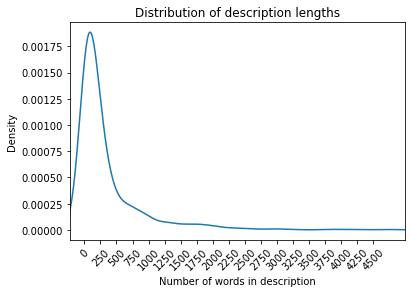

In [67]:
# Determine description length statistics for the full cleaned show data,
# which has been enriched with data about show episodes
description_length_statistics(df=df_data, description_length_col='enriched_description_length')

count  frequency
Drama                                               197   0.184457
Kids                                                130   0.121723
Education                                           121   0.113296
Documentary                                          97   0.090824
Family                                               75   0.070225
Comedy                                               69   0.064607
News and current affairs                             69   0.064607
Arts and culture                                     49   0.045880
Documentary, Family                                  36   0.033708
Arts and culture, Documentary                        27   0.025281
Education, Kids                                      25   0.023408
Comedy, Drama                                        22   0.020599
Lifestyle                                            22   0.020599
Family, Kids                                         18   0.016854
News and current affairs, Panel and discussion       18   0.016854
Documentary, Lifestyle                               14   0.013109
Education, Family                                    10   0.009363
Panel and discussion                                  9   0.008427
Comedy, Panel and discussion                          8   0.007491
Arts and culture, Documentary, Lifestyle              6   0.005618
Arts and culture, Education                           5   0.004682
Documentary, News and current affairs                 5   0.004682
Arts and culture, Family                              5   0.004682
Education, News and current affairs                   3   0.002809
Documentary, Education, Family                        3   0.002809
Arts and culture, Panel and discussion                3   0.002809
Arts and culture, Comedy, Documentary                 2   0.001873
Comedy, Family                                        2   0.001873
Arts and culture, Comedy                              2   0.001873
Arts and culture, Documentary, Family                 2   0.001873
Family, Lifestyle                                     2   0.001873
Documentary, Family, Lifestyle                        2   0.001873
Comedy, Documentary                                   1   0.000936
Arts and culture, Comedy, Documentary, Drama          1   0.000936
Comedy, Education, News and current affairs           1   0.000936
Documentary, Panel and discussion                     1   0.000936
Arts and culture, Comedy, Panel and discussion        1   0.000936
Arts and culture, Documentary, Education, Family      1   0.000936
Documentary, Drama                                    1   0.000936
Arts and culture, Lifestyle                           1   0.000936
Documentary, Education, News and current affairs      1   0.000936
Arts and culture, News and current affairs            1   0.000936

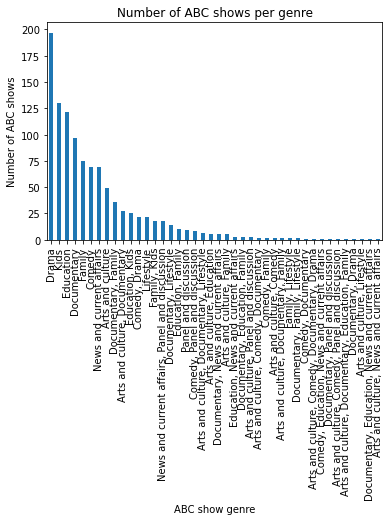

In [50]:
# Determine genre statistics for the full cleaned show data,
# which has not been enriched with data about show episodes
genre_statistics(df=df_data)

In [68]:
# Determine description length statistics for separate (combinations of) genres 
# for the full cleaned show data, which has not been enriched with data about show episodes
genre_description_statistics(df=df_data, description_length_col='enriched_description_length')

min   max         mean  \
genre                                                                       
Arts and culture                                    23  2478   184.428571   
Arts and culture, Comedy                            30  1264   647.000000   
Arts and culture, Comedy, Documentary             2240  2280  2260.000000   
Arts and culture, Comedy, Documentary, Drama        34    34    34.000000   
Arts and culture, Comedy, Panel and discussion      38    38    38.000000   
Arts and culture, Documentary                       22   822    99.111111   
Arts and culture, Documentary, Education, Family   499   499   499.000000   
Arts and culture, Documentary, Family               33   132    82.500000   
Arts and culture, Documentary, Lifestyle            23  1793   334.000000   
Arts and culture, Education                         26   449   146.800000   
Arts and culture, Family                            31    37    34.400000   
Arts and culture, Lifestyle                       2048  2048  2048.000000   
Arts and culture, News and current affairs         239   239   239.000000   
Arts and culture, Panel and discussion             245  1612   780.000000   
Comedy                                              21  1807   308.782609   
Comedy, Documentary                                 36    36    36.000000   
Comedy, Drama                                       29   694   139.818182   
Comedy, Education, News and current affairs       1445  1445  1445.000000   
Comedy, Family                                     203  1254   728.500000   
Comedy, Panel and discussion                        42  1558   403.625000   
Documentary                                         21  1745   112.969072   
Documentary, Drama                                  26    26    26.000000   
Documentary, Education, Family                     107   420   215.333333   
Documentary, Education, News and current affairs   282   282   282.000000   
Documentary, Family                                 24   608   104.111111   
Documentary, Family, Lifestyle                     129   314   221.500000   
Documentary, Lifestyle                              29   802   206.214286   
Documentary, News and current affairs               37  4737  1026.600000   
Documentary, Panel and discussion                  141   141   141.000000   
Drama                                               21  1995   156.137056   
Education                                           22  2991   359.735537   
Education, Family                                   38   706   336.900000   
Education, Kids                                    143  2988   652.800000   
Education, News and current affairs                170  1692   685.000000   
Family                                              25  2648   442.386667   
Family, Kids                                        30  4026   697.833333   
Family, Lifestyle                                  291   367   329.000000   
Kids                                                22  2875   664.607692   
Lifestyle                                           29  4298   659.863636   
News and current affairs                            24  3804   295.130435   
News and current affairs, Panel and discussion      25  1371   250.500000   
Panel and discussion                                27  1717   488.777778   

                                                  median  
genre                                                     
Arts and culture                                    35.0  
Arts and culture, Comedy                           647.0  
Arts and culture, Comedy, Documentary             2260.0  
Arts and culture, Comedy, Documentary, Drama        34.0  
Arts and culture, Comedy, Panel and discussion      38.0  
Arts and culture, Documentary                       32.0  
Arts and culture, Documentary, Education, Family   499.0  
Arts and culture, Documentary, Family               82.5  
Arts and culture, Documentary, Lifestyle            36.0  
Arts and cult

Minimum number of episodes per serie is:  1
Maximum number of episodes per serie is:  149
Mean number of episodes per serie is:  14
Median number of episodes per serie is:  6


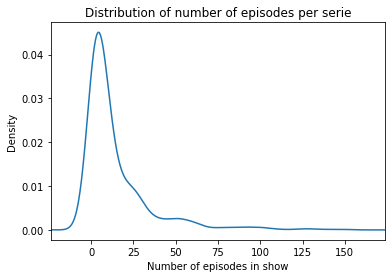

In [52]:
# Show number of episodes per serie statistics after cleaning
clean_episodes_per_show = df_episodes.groupby('show_id')
clean_count_episodes_per_show = clean_episodes_per_show.count()['episode_title']

clean_min_episodes = clean_count_episodes_per_show.min()
clean_max_episodes = clean_count_episodes_per_show.max()
clean_mean_episodes = clean_count_episodes_per_show.mean()
clean_median_episodes = clean_count_episodes_per_show.median()

print("Minimum number of episodes per serie is: ", clean_min_episodes)
print("Maximum number of episodes per serie is: ", clean_max_episodes)
print("Mean number of episodes per serie is: ", "{:.0f}".format(clean_mean_episodes))
print("Median number of episodes per serie is: ", "{:.0f}".format(clean_median_episodes))
    
# Plot number of episodes per show that contains episodes
clean_count_episodes_per_show.plot.kde()
plt.xlim(clean_min_episodes-25, clean_max_episodes+25)
plt.xlabel("Number of episodes in show")
plt.title("Distribution of number of episodes per serie")
plt.show()

### Data pre-processing

In [53]:
# Load clean data file from disk
folder_path = os.path.join(os.getcwd(), 'ABC_with_episodes')
df_data = pd.read_csv(os.path.join(folder_path, 'clean_data.csv'), sep=',')

In [54]:
# Inspect if clean data is correctly loaded
df_data.head()

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  id  \
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0   
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1   
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2   
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3   
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4   

                                enriched_description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

   enriched_description_length  
0                           36  
1                           38  
2                          856  
3                           39  
4                          456

In [55]:
df_data.description[2] # Show example description

"The journey to school is a very special type of life experience shared by millions of children around the world but in different ways. What happens between the two most important places in a child's life, home and school? Stages 2-3 HSIE, Stages 3-4 Geography."

In [56]:
df_data.enriched_description[2] # Show example enriched description

"The journey to school is a very special type of life experience shared by millions of children around the world but in different ways. What happens between the two most important places in a child's life, home and school? Stages 2-3 HSIE, Stages 3-4 Geography. Koolee is 10-years-old and lives in the small outback town of Winton in Central Western Queensland. Koolee is from the Waluwarra and Yirendali people. She loves to play sport, especially rugby league and running. In the Black Forest ranges of Germany, Annalena and her younger sister walk through the woods on their way to school. Annalena shares why her walk to school is so magical. Jaffer's a smart young boy. His road to school is a hard one, but at the same time an interesting one. He passes through various natural and historical places; a desert, oasis with green orchids as well as a historical place. Te Rautawhiri travels to school through the city of Christchurch, which is rebuilding itself after an earthquake. To is a littl

In [57]:
def tokenize(df_column=None, processed_texts = [], remove_punctuation=True, 
             to_lowercase=True, stop_words=[], word_types=[], to_lemma=True):
    """
    Tokenizes the text entries in df_column using spacy tokenizer 
    and filters this on supplied arguments, or processes the already
    tokenized texts of processed_texts further
    
    Parameters
    ----------
    df_column : pandas Series object (default None)
        Series with texts that need to be tokenized.
        If None is supplied, then processed_texts needs to be given to process that
        one further using the other arguments instead of tokenizing df_column from the start
    processed_texts : list of list of str (default [])
        List of tokenized texts that need to be further processed using the other arguments.
        If this is supplied, then df_column needs to be None
    remove_punctuation : bool (default True)
        Boolean stating if punctuation needs to be removed from the tokenized texts
    to_lowercase : bool (default True)
        Boolean stating if the tokenized texts need to be lowercased
    stop_words : list of str (default [])
        List with (lowercased) stop words to remove from the tokenized texts,
        with the default being no words to remove
    word_types : list of str (default [])
        List with word types to keep from the tokenized texts, which have to be
        one or multiple of the POS tags of Spacy (e.g. see here for examples
        https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/)
    to_lemma : bool (default True)
        Boolean stating if the tokenized texts need to be lemmatized

        
    Returns
    -------
    raw_processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column.
        This is a raw processed texts without taking the other arguments into
        account, such that still multiple different processing methods on the tokens can
        be done without needing to tokenize the full df_column anew
    processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column. 
        This is the fully processed texts that take all arguments into account
        to reach the desired tokenization result
    """
    # Preprocess dataset using Spacy tokenizer on texts in df_column, unless None is given,
    # then proceed by further processing the already supplied tokenized texts
    if df_column is not None:
        nlp = spacy.load("en_core_web_sm")
        processed_texts = [text for text in tqdm(nlp.pipe(df_column.values, 
                                                          disable=['ner', 'parser']),
                                                      total=len(df_column.values))]  
    
    # Remove spaces that are presented as an empty string 
    processed_texts = [[word for word in processed_text if not word.text.isspace()] 
                       for processed_text in processed_texts]
    
    raw_processed_texts = processed_texts.copy()
    
    # Remove punctuation if wanted
    if remove_punctuation:
        processed_texts = [[word for word in processed_text if not word.is_punct] 
                           for processed_text in processed_texts]
        
    # Remove the given stopwords if the list is not empty
    if stop_words:
        processed_texts = [[word for word in processed_text if not word.text in stop_words] 
                           for processed_text in processed_texts]
        
    # Filter on given word types if the list is not empty, e.g. 
    # proper nouns ('PROPN'), verbs ('VERB'), nouns ('NOUN') and adjectives ('ADJ')  
    if word_types:
        processed_texts = [[word for word in processed_text if word.pos_ in word_types] 
                           for processed_text in processed_texts]
    
    # Keep only lemmatized words if wanted
    if to_lemma:
        processed_texts = [[word.lemma_ for word in processed_text] 
                           for processed_text in processed_texts]
        
    # Lowercase the text if wanted. When it is lemmatized already, then each item is a string so directly
    # apply .lower() on it, and if it still is a token, then need to apply .text.lower().
    # Perform this as last step because the previous steps still require the spacy tokens
    if to_lowercase:
        processed_texts = [[word.lower() if isinstance(word, str) else word.text.lower() for word in processed_text] 
                           for processed_text in processed_texts]
    
    return raw_processed_texts, processed_texts

In [58]:
# Use standard list of English stopwords
stop_list = list(text.ENGLISH_STOP_WORDS)

In [59]:
# Tokenize all the enriched descriptions of shows, which can later be subsetted into different 
# sets of shows to compare. This prevents duplicated tokenizing of descriptions when subsets 
# overlap, which would take unneccessary computing power. Additionally, raw_processed_descr 
# can be further processed in different preprocessing ways, than is applied on processed_descr 
# below, as it is still the raw tokenized text. These can then also be compared with each other.
# Add the genre label also to the plot as additional input for the tokenizer to use for the 
# clusters later on (as same genre entails more similar shows with respect to their type)
raw_processed_descr, fully_processed_descr = tokenize(
    df_column=df_data.enriched_description+' '+df_data.genre, 
    processed_texts = [], remove_punctuation=True, to_lowercase=True, 
    stop_words=stop_list, word_types=['PROPN', 'VERB', 'NOUN', 'ADJ'], 
    to_lemma=True)

  0%|          | 0/1068 [00:00<?, ?it/s]

In [60]:
def vectorize_data(X, vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, norm='l2'):
    """
    Creates the vectorized data for e.g. performing k-means clustering.
    For this it uses already tokenized texts, which it vectorizes using a count or
    tf-idf vectorizer
    
    Parameters
    ----------
    X : list of lists of str
        List with a list of tokenized words per data entry, which will be vectorized.
        When a count vectorizer is used, make sure to have fully processed the texts
        already, while with the use of a tf-idf vectorizer no stop words etc. have to
        be removed beforehand as these will have a too high document frequency to
        be considered important words
    vectorizer : str (default 'tf-idf')
        String stating which kind of vectorization needs to be applied on X: 
        'count' for count vectorization, which simply counts how often a word occurs
        in each data entry
        'tf-idf' for TF-IDF vectorization, which weights how often a word occurs in
        other data entries as well to reflect how important a word is for a specific data entry
    MIN_DF : int (default 5)
        Minimum document frequency: the word should occur in at least MIN_DF 
        number of data entries
    MAX_DF : double (default 0.75)
        Maximum document frequency: the word should not occur in more than MAX_DF 
        fraction of the data entries
    norm : str (default 'l2')
        String stating which unit norm should be applied to each output row when
        tf-idf vectorization has been applied:
        'l2': Sum of squares of vector elements is 1. The cosine similarity 
            between two vectors is their dot product when l2 norm has been applied
        'l1': Sum of absolute values of vector elements is 1
        
    Returns
    -------
    X_vect : list of lists of int
        List with the vectorized data entries for the dataset
    vocabulary : list of str
        List with the unique words occuring in the dataset 
    """    
    # Use a count vectorizer on the already tokenized texts
    if vectorizer == 'count':
        cv_spacy = CountVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x,
                     min_df=MIN_DF, max_df=MAX_DF) 
        X_vect = cv_spacy.fit_transform(X)
        vocabulary = cv_spacy.get_feature_names()
        
    # Use a TF-IDF vectorizer on the already tokenized texts
    elif vectorizer == 'tf-idf':
        tfidf = TfidfVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x,
                                min_df=MIN_DF, max_df=MAX_DF, norm=norm) 
        tfidf.fit(X) # create the vocabulary
        X_vect = tfidf.transform(X)
        vocabulary = tfidf.get_feature_names() # The newer function .get_feature_names_out() needs scikit-learn > 1.0
    else:
        print("Choose one of the vectorization options: 'count' or 'tf-idf'")
        X_vect = X.copy()
        
    return X_vect, vocabulary

In [61]:
# Vectorize the tokenized descriptions using TF-IDF
# Min and Max df don't really matter for tf-idf as will scale it anyways.
# However, use min_df=0 instead of e.g. 5 for if there are less than that number of shows with 
# some diverser representation of communities, like aboriginals)
X_vect, vocabulary = vectorize_data(
        X=fully_processed_descr, vectorizer = 'tf-idf', MIN_DF=0, MAX_DF=0.9, norm='l2') 

C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [62]:
X_vect # Check size of matrix with tf-idf values

<1068x18401 sparse matrix of type '<class 'numpy.float64'>'
	with 112035 stored elements in Compressed Sparse Row format>

In [63]:
print("Total number of words in vocabulary of all show descriptions is: ", len(vocabulary))

Total number of words in vocabulary of all show descriptions is:  18401


### Pairwise distances between shows

In [64]:
def cosine_distance(vector_a, vector_b):
    """
    Compute pairwise cosine distances between vector_a and vector_b (may both contain 
    multiple show vectors).
    This applies the following formula:    
    a . b  -> dot(a, b)
    -----
    |a||b| -> norm(a) * norm(b)
    
    where dot(a,b) is computed using a linear_kernel of sklearn to be able to handle a sparse matrix,
    and the denominator is left out because tf-idf values are already l2 normalized.
    
    Code based on https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
    
    Parameters
    ----------
    vector_a : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the reference show for which
        to compute distances to vector_b to.
    vector_b : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the referenced show(s) for which
        to compute distances from vector_a to.
        
    Returns
    -------
    distances : list with numerical values
        List with cosine distances from vector_a to show(s) in vector_b, in the order
        of vector_b
    """    
    
    return linear_kernel(vector_a, vector_b).flatten() 

In [65]:
def find_closest_shows(vector_a, vector_b_list, vector_b_ids, n_shows=10):
    """
    For vector_a find the top n_shows number of shows from vector_b_list that are
    most similar in content based on cosine distance.
    Note: make sure that vector_a is not included in vector_b_list as otherwise that 
    one will be the closest returned show of course
    
    Code inspired by https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
    
    Parameters
    ----------
    vector_a : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the reference show for which
        to compute distances to vector_b to.
    vector_b_list : sparse matrix of normalized numerical values
        List with the vectorized data entries for the dataset (tf-idf values), 
        for which its sparse matrix is used as the referenced show(s) for which
        to compute distances from vector_a to. 
    vector_b_ids : list of int
        List in the same order as the shows in vector_b_list which contains the
        unique ids referencing its shows. This is used to be able to correctly 
        link a retrieved distance with the show in question. If this is not done, 
        then just indices will be returned relative to the slice of rows given in 
        vector_b_list instead of the actual ids of shows
        
    Returns
    -------
    closest_show_indices : list of int
        Ordered list with the indices of the top n_shows number of shows that
        are closest to the show of vector_a, ordered from most to least similar
    closest_distances : list of numerical values
        Ordered list in the same order as closest_show_indices with its corresponding
        cosine distance between the show of vector_a and the corresponding show of
        vector_b_ids
    """    
    # Compute the cosine distance between vector_a and the shows in vector_b_list
    distances = cosine_distance(vector_a, vector_b_list)     
    
    # Get the vector_b_list indices of top n_shows shows that are indexed relative to 
    # vector_b_list (need +1 else get one show too little) 
    # Ordered from big to small (most to least similar) 
    closest_indices = distances.argsort()[:-(n_shows+1):-1]     
    
    # Retrieve the corresponding distances of the top_n shows
    closest_distances = distances[closest_indices] 
    
    # Get the unique show ids corresponding to the closest shows to be able to retrieve
    # information about these shows from the dataframe
    closest_show_indices = [vector_b_ids[i] for i in closest_indices]    
    
    # Return the ids and distances of n_shows closest shows to vector_a
    return closest_show_indices, closest_distances  

In [74]:
# For each show determine the cosine similarity distance to all other shows,
# which can later be used to determine the top N closest shows within or outside
# the K-means cluster of a specific show, or towards shows that are showing diverse
# representations due to including words about minority/oppressed groups in their description

closest_shows = []

# Loop through the tf-idf values of each show (which are based on its description 
# and genre label(s))
for i, vector in tqdm(enumerate(X_vect), total=X_vect.shape[0]):
    # Retrieve ids of all shows apart from the current one 
    # (as otherwise the closest show will be the show itself)
    # other_show_indices refers to the indices in the df_data table (0 till number of shows),
    # which corresponds to the indices of X_vect, while other_show_ids
    # refers to the ids in the id column of the shows themself, which
    # do not have to correspond to each other due to shows having been
    # removed during the cleaning stage
    
    # i corresponds directly to the index value in other_show_indices
    other_show_indices = list(range(len(df_data)))
    other_show_indices.remove(i) 
    
    # i corresponds to the index of the show id within other_show_ids, not the value itself,
    # so use pop to get the id value at index i
    other_show_ids = list(df_data['id']) 
    show_id = other_show_ids.pop(i)
    
    # Determine pairwise cosine similarities to all other shows (and return distance to all, 
    # which is ordered from most to least similar)
    closest_ind, closest_dist = find_closest_shows(vector_a=vector, 
                                                    vector_b_list=X_vect[other_show_indices],
                                                    vector_b_ids=other_show_ids, 
                                                    n_shows=len(other_show_ids))
    # Add row with own vector index, index of other show, 
    # and the cosine distance between them
    for ind, dist in zip(closest_ind, closest_dist):
        closest_shows.append([show_id, ind, dist]) 

  0%|          | 0/1068 [00:00<?, ?it/s]

In [75]:
# Create dataframe from the list, which contains the most to least similar shows for each show
df_closest = pd.DataFrame(closest_shows, columns=['id_a', 'id_b', 'cosine_distance'])

In [76]:
# Inspect dataframe
df_closest.head()

id_a  id_b  cosine_distance
0     0   748         0.101629
1     0   163         0.098242
2     0   793         0.086252
3     0   919         0.086157
4     0   927         0.084395

In [77]:
# Inspect if the correct number of cosine distances is calculated to have
# a distance between each pair of shows (distance to own show is excluded so subtracted here)
print("The total number of calculated cosine distances is ", len(df_closest),
     ", which should be ", len(df_data)**2 - len(df_data), " combinations of shows")
print("Truthvalue of these numbers being equal: ", 
      len(df_closest) == len(df_data)**2 - len(df_data))

The total number of calculated cosine distances is  1139556 , which should be  1139556  combinations of shows
Truthvalue of these numbers being equal:  True


In [78]:
# Save the data with closest show ids to .csv files
df_closest.to_csv(os.path.join(folder_path, 'cosine_distances.csv'), 
                                 index=False, sep=',')

### Show clustering

In [79]:
# Determine an optimal number of clusters for KMeans using the elbow technique:
# run K-Means for a range of K and determine where the 'elbow' is of distortions.
# There are 11 main genres so probably best to take that as minimum number of clusters
# Code inspired by https://predictivehacks.com/k-means-elbow-method-code-for-python/
distortions = []
K = range(1,50)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_vect)
    distortions.append(kmeanModel.inertia_)

  0%|          | 0/49 [00:00<?, ?it/s]

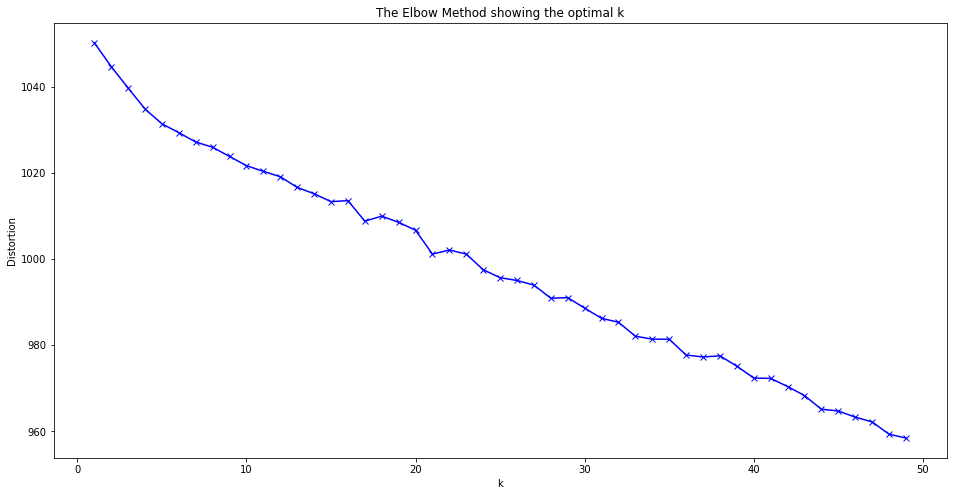

In [80]:
# Plotting the distortions of K-Means, from which the elbow can visually be determined
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [81]:
# Perform K-means clustering to get clusters with similar shows
# Code adjusted from analysis.ipynb of streamlit example (provided by teachers of the course)
n_clusters = 15  # This is the used K determined above
kmeanModel = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=3000, random_state=0)
mod = kmeanModel.fit_transform(X_vect)
df_data['k_means_cluster'] = kmeanModel.predict(X_vect)

In [82]:
# Inspect words corresponding to the generated clusters
# Code adjusted from analysis.ipynb of streamlit example (provided by teachers of the course)
order_centroids = kmeanModel.cluster_centers_.argsort()[:, ::-1]
dict = []
for i in range(n_clusters):
    print('%d' % i, sep='', end=', '),
    for ind in order_centroids[i, :10]:
        print(vocabulary[ind], sep='', end=', ')
    print('')

0, science, geography, stage, education, human, explore, earth, natural, scientist, planet, 
1, news, abc, reporting, story, original, present, current, today, issue, affair, 
2, child, dog, beach, cadet, neville, kangaroo, play, drama, kids, frizzy, 
3, david, attenborough, documentary, sir, family, animal, speers, reef, extraordinary, ancient, 
4, maddie, join, everyday, wil, plant, food, space, carbon, find, emission, 
5, indigenous, australia, people, report, australian, year, aboriginal, landline, nation, life, 
6, daniel, bluey, bingo, play, school, humpty, joey, athlete, dad, mouse, 
7, art, culture, ballet, australian, documentary, artist, music, perform, orchestra, australia, 
8, emma, kid, school, special, episode, big, play, join, wash, ask, 
9, story, documentary, life, mark, disability, drama, secret, comedy, truth, funny, 
10, australia, documentary, pedersen, aaron, story, culture, chinese, experience, artist, explore, 
11, drama, life, young, world, family, murder, fina

In [83]:
# Create a list with lists of indices of vectors that belong to which K-Means cluster
cluster_indices = []
for i in range(n_clusters):
    indices = df_data[df_data.k_means_cluster == i]['id']
    cluster_indices.append(indices)

In [84]:
# Check how many items are contained in each cluster
for i, cluster in enumerate(cluster_indices):
    print("Cluster ", i, " contains ", len(cluster), " shows")

Cluster  0  contains  53  shows
Cluster  1  contains  23  shows
Cluster  2  contains  36  shows
Cluster  3  contains  25  shows
Cluster  4  contains  24  shows
Cluster  5  contains  48  shows
Cluster  6  contains  13  shows
Cluster  7  contains  73  shows
Cluster  8  contains  42  shows
Cluster  9  contains  42  shows
Cluster  10  contains  49  shows
Cluster  11  contains  328  shows
Cluster  12  contains  59  shows
Cluster  13  contains  142  shows
Cluster  14  contains  111  shows


In [85]:
# Code from 02-TF-IDF with K-means clustering.ipynb (provided by teachers of the course).
# and I added documentation
def plot(dense_tfidf, k):
    """
    Reduces the dense_tfidf data to a dimensionality of 2, trains a K-Means clustering
    model on it with k clusters, and creates a 2D visualisation out of its results. 
    This way the clustering results of higher dimension data can be visually inspected 
    
    Parameters
    ----------
    dense_tfidf : matrix of numerical values
        List with the vectorized data entries for the dataset (e.g. tf-idf values), 
        for which its sparse matrix is converted into a dense matrix
    k : int 
        Number of clusters to create using K-Means clustering
    """    
    h = 0.2
    reduced_data = PCA(n_components=2).fit_transform(dense_tfidf)

    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(reduced_data)

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                   cmap=plt.cm.Paired,
                   aspect='auto', origin='lower')

    centroids = kmeans.cluster_centers_
    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=169, linewidths=3,
                    color='r', zorder=10)
    plt.title('K-means clustering of ABC iview shows')

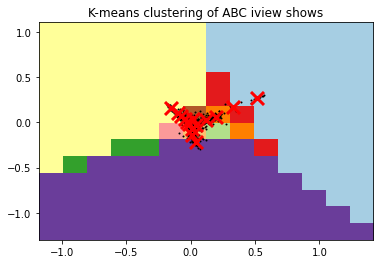

In [86]:
# Code adjusted from 02-TF-IDF with K-means clustering.ipynb (provided by teachers of the course)

# Visualise KMeans clusters in 2D (so reduce its dimensionality)
d_matrix = dok_matrix(X_vect).todense()

plot(dense_tfidf=d_matrix, k=n_clusters)

In [87]:
# Check if clusters make sense by displaying some show titles belonging to clusters
df_data[df_data['k_means_cluster'] == 0]['title'].head(10)

72                                                Arthur
86     Australia's Ocean Odyssey: A Journey Down The ...
90                           Australia: The Wild Top End
100                       Back To Earth: Stargazing Live
102                                       Bad Influencer
166                              BTN: Antarctica Special
181                                Can We Save The Reef?
184            Carbon And Water Cycles In The Rainforest
185       Carbon Cycles And Climate Change In The Tundra
186                                             Catalyst
Name: title, dtype: object

In [88]:
# Inspect dataset that now contains cluster numbers
df_data.head() 

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  id  \
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0   
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1   
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2   
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3   
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4   

                                enriched_description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

   enriched_description_length  k_means_cluster  
0                           36               11  
1                           38               11  
2                          856               13  
3                           39                4  
4                          456               12

In [89]:
# Save the data with clusters to .csv file
df_data.to_csv(os.path.join(folder_path, 'clustered_shows.csv'), index=False, sep=',')

### Representation diverse shows

#### Feminine representation using gender bias

This part is based on the gender bias analysis of Wevers, M. (2019). _Using word embeddings to examine gender bias in dutch newspapers, 1950-1990_. arXiv. Retrieved from https://arxiv.org/abs/1907.08922. The file with English versions of the lists of category words they used is created by the teachers of the course _Data mining: text, images, video_ (2021) of MSc Applied Data Science at Utrecht University. A word embedding model will be created for each show, which will include the inherent biases in the description texts. Then male and female related words will be compared to words from certain categories (e.g. job-related words, emotion-related words, family-related words) to check if these words are learned to be closer to the male or the female related words, or if it is more neutral. This way shows can be selected that are more biased towards females.

In [90]:
# A word embedding model takes the context of words into account, 
# so instead of fully processing the tokens as before, 
# the raw tokens only have to be lowercased and cleaned of punctuation
_, partly_processed_descr = tokenize(df_column=None, 
                                        processed_texts = raw_processed_descr, 
                                        remove_punctuation=True, 
                                        to_lowercase=True, stop_words=[], 
                                        word_types=[], 
                                        to_lemma=False)

In [91]:
def train_embedding_model(tokenized_texts, SIZE=300, SG=1, WINDOW=10, N_WORKERS=1, MIN_COUNT=5):
    """
    Trains word2vec word embedding model on tokenized_texts
    
    Parameters
    ----------
    tokenized_texts : list of lists of strings
        List with a list of tokenized words per data entry
    SIZE : int (default 300)
        Dimension of the word embeddings
    SG : int (default 1)
        Whether to use skip-gram (1) or contonuous bag-of-words (0) for training the model
    WINDOW : int (default 10)
        Window size of context around word
    N_WORKERS : int (default 1)
        Number of workers to use for parallel training
    MIN_COUNT : int (default 5)
        Minimum document frequency, as very infrequent words are often unimportant
        
    Returns
    -------
    model : Word2Vec object
        Trained Word2Vec model
    """
    # Initialize Word2Vec model
    model = Word2Vec(size=SIZE,
                    sg=SG,
                    window=WINDOW, 
                    min_count=MIN_COUNT,
                    workers=N_WORKERS)

    # Build vocabulary from tokenized texts
    model.build_vocab(tokenized_texts)

    # Train Word2Vec model on tokenized texts
    model.train(tokenized_texts,
               total_examples=model.corpus_count,
               epochs=model.epochs) 
    return model

In [92]:
# Load data from word_cats.p file, to do gender bias analysis similar to Wevers
# Make sure the file is in the same directory as this Jupyter Notebook file
df_words = pickle.load(open('word_cats.p', 'rb'))

# Inspect dataframe to see what attributes it contains: categories and words related to these
df_words.head()

affect     posemo       negemo   social   family     cogproc percept  \
0  protesting  incentive  destruction    chick     ma's      comply  squeez   
1      pretty       luck       beaten     ma's    niece        luck    sand   
2       sighs    freeing        battl     lets  stepkid  unquestion   moist   
3      warmth     pretty   protesting    son's    son's      pretty  warmth   
4       mooch     nicely       dumber  daddies  daddies      become  gloomy   

     body      work   leisure      money    relig     occupation  
0   pussy    dotcom       dnd  portfolio  goddess     accountant  
1   wears  employee  vacation       sale    karma          actor  
2  hearts     paper      hobb     stores   pastor        actress  
3  asleep     earns      band       bets   temple        actuary  
4    gums    assign      skat       bank     holy  acupuncturist

In [93]:
# Make list of male and female related words inspired by Wevers
# (including plurals as words are not lemmatized during preprocessing)
male_words = ['he', 'him', 'his', 'male', 'males', 'man', 'men', 'boy', 'boys', 
              'guy', 'guys', 'patriarchy', 'father', 'fathers', 'son', 'sons', 
              'grandfather', 'grandfathers', 'grandpa', 'grandpas', 'brother', 'brothers', 
              'nephew', 'nephews', 'uncle', 'uncles', 'sir']
female_words = ['she', 'her', 'hers', 'female', 'females', 'woman', 'women', 'madam', 'girl', 
                'girls', 'matriarchy', 'mother', 'mothers', 'daughter', 'daughters', 
                'grandmother', 'grandmothers', 'grandma', 'grandmas', 'sister', 'sisters', 
                'aunt', 'aunts', 'niece', 'nieces']

In [94]:
def calculate_gender_bias(df_gender, category, male_words, female_words, model):
    """
    Determines the gender bias in a trained word2vec model for a specified category of words 
    in df_gender, based on Frobenius distances between words in the specified category and 
    an average word embedding of male and female related words that exist in the vocabulary 
    of the model
    
    Parameters
    ----------
    df_gender : pandas dataframe
        Dataframe containing words belonging to specific categories
    category : string
        Category in df_gender to calculate the gender bias for each of its words for, and the mean of those biases
    male_words : list of strings
        List containing words related to the male gender to compute a mean word embedding for and 
        to compare that against words in the category
    female_words : list of strings
        List containing words related to the female gender to compute a mean word embedding for and
        to compare that against words in the category
    model : Word2Vec object
        Trained Word2Vec model of which the gender bias will be assessed
        
    Returns
    -------
    df_category_gender : pandas dataframe
        Dataframe containing a gender bias value for each word in the specified category
    mean_category_gender : float
        Value specifying the mean gender bias over all words in the specified category
    """
    # Determine mean embedding of male and female related words, 
    # by only taking into account the words in the model's vocabulary 
    # If none of these words are in the vocabulary then this will be NaN
    male_words = [word for word in male_words if word in model.wv.vocab] 
    female_words = [word for word in female_words if word in model.wv.vocab] 

    mean_embedding_male = np.mean([model.wv[word] for word in male_words], axis=0)
    mean_embedding_female = np.mean([model.wv[word] for word in female_words], axis=0)
    
    # Initialize list for dictionaries to save words in the specified category with their 
    # gender bias
    dic_category_gender = []

    # Loop through the words in the category that are in the vocabulary of the model
    for word in df_gender[category].values:
        if word in model.wv.vocab:
            # Get word embedding of category word
            word_wv = model.wv[word]

            # Calculate Frobenius-based distance between category word and mean male & 
            # female related words embedding
            # If there is no mean embedding of male and female related words then this will be NaN
            male_distance = np.linalg.norm(np.subtract(word_wv, mean_embedding_male))
            female_distance = np.linalg.norm(np.subtract(word_wv, mean_embedding_female)) 
            
            # Calculate difference between distance from category word to male and female mean embeddings
            # If male_distance and female_distance are both NaN, then there is no bias to either
            # of these two genders on the gender spectrum, so 0 gender bias
            # Else if one of the two is NaN, then the bias is towards the one represented, 
            # and otherwise just the difference between the two
            if np.isnan(male_distance) and np.isnan(female_distance):
                gender_bias = 0
            elif np.isnan(male_distance):
                gender_bias = female_distance
            elif np.isnan(female_distance):
                gender_bias = -male_distance 
            else:
                gender_bias = male_distance - female_distance

            # Store category word with its gender bias in a dictionary and add it to the list
            category_gender = {category:word,
                                'gender_bias':gender_bias}
            dic_category_gender.append(category_gender)

    # Create dataframe out of dictionary
    # If no words of this category were in the vocabulary, then will be empty dataframe
    df_category_gender = pd.DataFrame(dic_category_gender, columns=[category, 'gender_bias'])

    # Calculate mean gender bias over all words in the category
    # If no words of this category were in the vocabulary, then this will be NaN
    mean_category_gender = df_category_gender['gender_bias'].mean()
    
    return df_category_gender, mean_category_gender

In [95]:
def all_mean_gender_bias(df_gender, male_words, female_words, model):
    """
    Determines the (mean) gender bias in a trained word2vec model for each category of words in df_gender,
    based on the function calculate_gender_bias(df_gender, category, male_words, female_words, model)
    
    Parameters
    ----------
    df_gender : pandas dataframe
        Dataframe containing words belonging to specific categories
    male_words : list of strings
        List containing words related to the male gender to compute a mean word embedding for and 
        to compare that against words in each category
    female_words : list of strings
        List containing words related to the female gender to compute a mean word embedding for and
        to compare that against words in each category
    model : Word2Vec object
        Trained Word2Vec model of which the gender bias will be assessed
        
    Returns
    -------
    df_all_category_gender : pandas dataframe
        Dataframe containing a gender bias value for each word in each category of df_gender 
        that is in the vocabulary of the model 
    df_mean_biases : pandas dataframe
        Dataframe containing a mean gender bias value for each category in df_gender
    """
    # Initialize list for dictionaries to save categories with their mean gender bias
    dic_mean_biases = []
    
    # Initialize data frame for gender bias values of category words
    df_all_category_gender = pd.DataFrame(columns=df_gender.columns)
    
    # Loop through all categories in df_gender to calculate their mean gender bias
    for category in df_gender.columns:
        df_category_gender, mean_category_gender = calculate_gender_bias(df_gender=df_gender, category=category, male_words = male_words, female_words = female_words, model=model)

        # Fill in gender biases for category words into df_all_category_gender 
        df_all_category_gender[category] = df_category_gender['gender_bias']
        
        # Store category with its mean gender bias in a dictionary and add it to the list
        mean_bias = {'category':category,
                    'mean_gender_bias':mean_category_gender}
        dic_mean_biases.append(mean_bias)

    # Create dataframe out of dictionary and return it along with df_all_category_gender
    return df_all_category_gender, pd.DataFrame(dic_mean_biases)

In [96]:
# Create a word embedding model for each show to represent the individual gender biases
show_gender_biases = []
for show_tokens in tqdm(partly_processed_descr, total=len(partly_processed_descr)):
    show_model = train_embedding_model([show_tokens], MIN_COUNT=0)
    
    # Determine the gender bias among all words in categories of Wevers, and an average
    # per category. Note that not all category or male/female related words are present
    # in the vocabulary of each show description, which will in that case be skipped.
    # If all words in a certain category are not included in the vocabulary, then
    # the category will not at all show up in the dataframes below
    _, df_mean_biases = all_mean_gender_bias(df_gender=df_words, 
                                                male_words = male_words, 
                                                female_words = female_words, 
                                                model=show_model)
    # Calculate the mean gender bias over all categories that are represented in the vocabulary
    # If a category was not represented in the show vocabulary, then it will have a mean
    # gender bias of NaN, which will be excluded by calculating the mean gender bias over all 
    # represented categories below. If none of the category words were included, then this
    # will return NaN, which will be replaced by 0 to say that this show doesn't have gender bias
    mean_gender_bias = df_mean_biases['mean_gender_bias'].mean()
    if np.isnan(mean_gender_bias):
        mean_gender_bias = 0
    show_gender_biases.append(mean_gender_bias)    

  0%|          | 0/1068 [00:00<?, ?it/s]

C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\sande\Anaconda3\envs\Data_wrangling\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [97]:
# Display statistics of mean gender bias of all categories over all shows
# High negative or positive gender bias (close to -1 or +1) means that one of the 
# gender related word lists was not in the vocabulary of a show
# The minimum and maximum value are likely from shows that didn't contain respectively
# female or male reprenting words in their description
print('The minimum gender bias (if negative then biased towards male related words) of all shows is: {:.2f}'.
      format(min(show_gender_biases)))
print('The maximum gender bias (if positive then biased towards female related words) of all shows is: {:.2f}'.
      format(max(show_gender_biases)))
print('The mean gender bias (if 0 then not gender biased) of all shows is: {:.2f}'.
      format(np.mean(show_gender_biases)))
print('The median gender bias of all shows is: {:.2f}'.
      format(np.median(show_gender_biases)))
print('The number of shows without gender bias (likely due to not having one of the category words in their description) is: {} of {} shows'.
      format(show_gender_biases.count(0), len(show_gender_biases)))

The minimum gender bias (if negative then biased towards male related words) of all shows is: -0.37
The maximum gender bias (if positive then biased towards female related words) of all shows is: 0.73
The mean gender bias (if 0 then not gender biased) of all shows is: 0.00
The median gender bias of all shows is: 0.00
The number of shows without gender bias (likely due to not having one of the category words in their description) is: 362 of 1068 shows


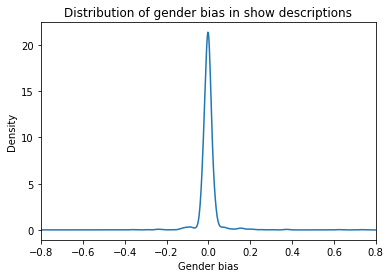

In [104]:
# Show distribution of gender bias over all shows
pd.DataFrame(show_gender_biases).plot.kde()
plt.xlim(-0.8, 0.8)
plt.xlabel("Gender bias")
plt.title("Distribution of gender bias in show descriptions")
plt.legend().remove()
plt.show()

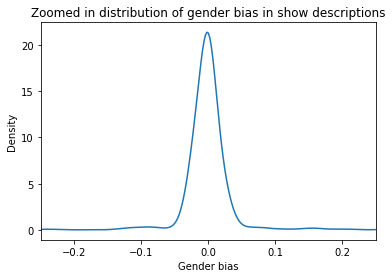

In [108]:
# Show zoomed in distribution of gender bias over all shows
pd.DataFrame(show_gender_biases).plot.kde()
plt.xlim(-0.25, 0.25)
plt.xlabel("Gender bias")
plt.title("Zoomed in distribution of gender bias in show descriptions")
plt.legend().remove()
plt.show()

For interpreting the gender bias columns in the tables produced by the function(s) and plot above: Frobenius norm distance (between category word and mean (fe)male word embedding) indicates that two words are really similar when the result is closer to 0. Here two of such distances are subtracted from each other, giving a negative value if the word is more associated with the male word embedding than with the female word embedding (I did 'male_gender_bias - female_gender_bias' so e.g. more biased to male means that male_gender_bias is lower than female_gender_bias so a negative resulting value of the subtraction), and a positive value if it is the other way around. Further, if there is similar distance to male and female word embeddings, then we get a resulting gender bias around 0.

In [100]:
# Add the mean gender bias of each show to the dataframe
df_data['gender_bias'] = show_gender_biases

In [101]:
# Inspect dataframe with gender bias
df_data.head()

title  \
0            100 Bloody Acres   
1                13 Assassins   
2           199 Little Heroes   
3            30 Days Of Night   
4  7.30 Mark Humphries Satire   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   

                                           image_url  description_length  id  \
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0   
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1   
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2   
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3   
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4   

                                enriched_description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   

   enriched_description_length  k_means_cluster  gender_bias  
0                           36               11    -0.020405  
1                           38               11    -0.019051  
2                          856               13    -0.006951  
3                           39                4     0.000000  
4                          456               12    -0.020988

#### Minority/ oppressed group representation

In [109]:
# Create vocabularity with tokens describing minority/oppressed groups to be able to infer 
# from description tokens if a show is likely to enhance representation diversity.
# This specifically also contains the word 'aboriginal', which is a relevant community for 
# Australia. Note that words like black and brown don't have to refer to person's skin colour 
# but may also be about some random object (as tokens don't include context), which may give 
# wrong annotations of shows being diverse. On the other hand, shows that don't explicitly 
# mention these words in their descriptions may still contain diverse representation but 
# are then just not about these communities specifically and hence will be incorrectly missed.
# Words are from following sources and own additional brainstorm:
# https://openstax.org/books/introduction-sociology-3e/pages/11-1-racial-ethnic-and-minority-groups
# https://www.cosmopolitan.com/sex-love/a24442815/sexual-orientation-list-definitions/
# https://www.sciencedirect.com/science/article/pii/B9780080449104007756
# https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww2.ohchr.org%2Fenglish%2Fissues%2Fminorities%2Fdocs%2FWP2.doc&wdOrigin=BROWSELINK
# First split up into separate lists for subgroups of representation diversity, and then combined

# Aboriginal peoples, Torres Strait Islanders and South Sea Islanders are indigenous to Australia
indigenous_words = ['indigenous', 'native', 'aboriginal', 'torres', 'islander'] 

# The indigenous groups in Australia belong to BIPOC community so added here
bipoc_words = indigenous_words + ['race', 'racial', 'racism', 'racist', 'ethnic', 'ethnicity',
                                 'bipoc', 'black', 'brown', 'asian', 'african', 'african-american', 
                                  'arabic', 'arab', 'colonialism', 'colony'] 
# LGBTQ+ community
lgbtq_words = ['lgbt', 'lgbt+', 'lgbtq', 'lgbtq+', 'lgbti', 'lgbti+', 'lgb',
              'lesbian', 'gay', 'homo', 'homosexual', 'bi', 'bisexual', 'trans', 'transgender',
              'transsexual', 'non-binary', 'agender', 'asexual', 'aromantic', 'intersex',
               'intersexual','queer', 'pansexual', 'heteronormative', 'demisexual']

# Here combine the above specified communities and other words referring to different minority/
# oppressed groups (of course all may overlap)
diversity_words = indigenous_words + bipoc_words + lgbtq_words + ['polyamorous', 'disability', 
                    'disabled', 'religion', 'muslim', 'jew', 'jewish', 'immigrant', 'refugee', 
                    'asylum', 'minority', 'oppressed', 'oppression', 'marginalised', 'homeless', 
                    'discrimination', 'discriminated'] 

# Make a sublist of diversity_words that are included in the vocabulary of the dataset 
diversity_words_included = []
for word in diversity_words:
    if word in vocabulary: 
        print(f'The word \033[4m{str(word)}\033[0m is contained in the vocabulary')
        
        # Add word to list with all included diversity words because it is in the vocabulary
        diversity_words_included.append(word) 
    else:
        print(f'The word \033[4m{str(word)}\033[0m is \033[1m not \033[0m contained in the vocabulary')
        
print('\nDiversity words included in the vocabulary are (', len(diversity_words_included), 
      ' of ', len(diversity_words), ') :\n', diversity_words_included)

# Make sublists for the specified communities of included diversity words in the vocabulary
indigenous_words_included = []
bipoc_words_included = []
lgbtq_words_included = []
for word in diversity_words_included:
    if word in indigenous_words:
        indigenous_words_included.append(word)
    elif word in bipoc_words:
        bipoc_words_included.append(word)
    elif word in lgbtq_words:
        lgbtq_words_included.append(word)
    # Else the word is a diversity word from another minority/oppressed group or just
    # generally referring to all communities
    
print('\nIndigenous words included in the vocabulary are (', len(indigenous_words_included), 
      ' of ', len(indigenous_words), ') :\n', indigenous_words_included)

print('\nBIPOC words included in the vocabulary are (', len(bipoc_words_included), 
      ' of ', len(bipoc_words), ') :\n', bipoc_words_included)

print('\nLGBTQ+ words included in the vocabulary are (', len(lgbtq_words_included), 
      ' of ', len(lgbtq_words), ') :\n', lgbtq_words_included)

The word indigenous is contained in the vocabulary
The word native is contained in the vocabulary
The word aboriginal is contained in the vocabulary
The word torres is contained in the vocabulary
The word islander is contained in the vocabulary
The word indigenous is contained in the vocabulary
The word native is contained in the vocabulary
The word aboriginal is contained in the vocabulary
The word torres is contained in the vocabulary
The word islander is contained in the vocabulary
The word race is contained in the vocabulary
The word racial is contained in the vocabulary
The word racism is contained in the vocabulary
The word racist is contained in the vocabulary
The word ethnic is contained in the vocabulary
The word ethnicity is  not  contained in the vocabulary
The word bipoc is  not  contained in the vocabulary
The word black is contained in the vocabulary
The word brown is contained in the vocabulary
The word asian is contained in the vocabulary
The word african is contained i

In [120]:
# Create a list with show ids that contain one or more of the representation words in their tokens
closest_representation_id = []
for i, tokens in enumerate(fully_processed_descr):
    # Check if the tokens contain any of the representation diversity words 
    # (that are in the vocabulary) and if so add the show id to a list
    if any(item in tokens for item in diversity_words_included):
        closest_representation_id.append(df_data.id.iloc[i])

In [122]:
# Check how many shows are included in the list with representation diversity shows
print("There are ", len(closest_representation_id), 
      " shows in the ABC iview dataset that contain a representation diverse word in their description.")

There are  260  shows in the ABC iview dataset that contain a representation diverse word in their description.


In [123]:
# Add a column to the dataframe to indicate if a show contains diverse representation (1)
# or not (0)
df_data['representation_diverse'] = [1 if show_id in closest_representation_id else 0 
                                     for show_id in df_data['id']]

In [126]:
# List 10 show titles with representation diversity
df_data[df_data.representation_diverse == 1]['title'].head(10)

2                       199 Little Heroes
8                       72 Cutest Animals
9                                    8MMM
11            ABC Education Good Mornings
21                      ABC News Regional
23                       ABC News Stories
26                     ABC News Video Lab
37           The Adventures Of Paddington
38          Advice To My 12 Year Old Self
42    Against All Odds: Inside Statistics
Name: title, dtype: object

In [128]:
# Show snippet of the descriptions of above titles
df_data[df_data.representation_diverse == 1]['description'].head(10) 

2     The journey to school is a very special type o...
8     The animal kingdom continually astounds us wit...
9     An Indigenous crew from a remote radio station...
11    How would you greet someone in the language of...
21    Miriam Corowa brings you a closer look at what...
23    Watch some of the special features, stories, i...
26    The ABC News Video Lab explains the events and...
37    The Adventures of Paddington is a new version ...
38    A range of talented Australians, including som...
42    This series maintains the same emphasis on doi...
Name: description, dtype: object

In [132]:
# Determine the row indices (in df_data and processed descriptions) 
# that correspond to show ids of representation diverse shows
closest_representation_indices = list(df_data[df_data.representation_diverse == 1].index)

In [136]:
# Create lists with show ids that contain one or more of the representation words 
# of specific minority/ oppressedcommunities in their tokens 
# This are (potentially overlapping due to multiple identities) 
# subgroups of closest_representation_id
indigenous_representation_id = []
bipoc_representation_id = []
lgbtq_representation_id = []

# i corresponds to the row index in df_data and fully_processed_descr at which the show id
# of representation diverse shows corresponds (these don't have to be equal)
for i in tqdm(closest_representation_indices, total=len(closest_representation_indices)):
    # Retrieve tokens of representation diverse show using the row index i
    tokens = fully_processed_descr[i]
    
    # Check if the tokens contain any of the specific representation diversity words 
    # (that are in the vocabulary) and if so, add the corresponding show id to list
    if any(item in tokens for item in indigenous_words_included):
        indigenous_representation_id.append(df_data.id.iloc[i])
    if any(item in tokens for item in bipoc_words_included):
        bipoc_representation_id.append(df_data.id.iloc[i])
    if any(item in tokens for item in lgbtq_words_included):
        lgbtq_representation_id.append(df_data.id.iloc[i])

  0%|          | 0/260 [00:00<?, ?it/s]

In [137]:
# Add columns to the dataframe to indicate if a show contains specific diverse representation (1)
# or not (0)
df_data['indigenous_representation'] = [1 if show_id in indigenous_representation_id else 0 
                                     for show_id in df_data['id']]
df_data['bipoc_representation'] = [1 if show_id in bipoc_representation_id else 0 
                                     for show_id in df_data['id']]
df_data['lgbtq_representation'] = [1 if show_id in lgbtq_representation_id else 0 
                                     for show_id in df_data['id']]

In [138]:
# Inspect the new dataframe containing a column with representation diverse binary values
df_data.head(8)

title  \
0                         100 Bloody Acres   
1                             13 Assassins   
2                        199 Little Heroes   
3                         30 Days Of Night   
4               7.30 Mark Humphries Satire   
5  7.30 Special: The Shane Warne Interview   
6                     7.30: The Interviews   
7                                     7.30   

                                         description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   
5  Shane Warne has died of a suspected heart atta...   
6  Revisit some of 7.30's most compelling convers...   
7  Leigh Sales presents Australia's leading night...   

                      genre  \
0             Comedy, Drama   
1                     Drama   
2                 Education   
3                     Drama   
4  News and current affairs   
5  News and current affairs   
6  News and current affairs   
7  News and current affairs   

                                         website_url  \
0  https://iview.abc.net.au/show/100-bloody-acres...   
1  https://iview.abc.net.au/show/13-assassins/vid...   
2    https://iview.abc.net.au/show/199-little-heroes   
3  https://iview.abc.net.au/show/30-days-of-night...   
4  https://iview.abc.net.au/show/7-30-mark-humphr...   
5  https://iview.abc.net.au/show/7-30-special-the...   
6  https://iview.abc.net.au/show/7-30-the-interviews   
7                 https://iview.abc.net.au/show/7-30   

                                           image_url  description_length  id  \
0  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW297...                  36   0   
1  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW284...                  38   1   
2  https://cdn.iview.abc.net.au/thumbs/i/zw/publi...                  45   2   
3  https://cdn.iview.abc.net.au/thumbs/i/zw/ZW285...                  39   3   
4  https://cdn.iview.abc.net.au/thumbs/i/ma/MARK2...                  13   4   
5  https://cdn.iview.abc.net.au/thumbs/i/ns/NS188...                  36   5   
6  https://cdn.iview.abc.net.au/thumbs/i/ns/NS224...                  17   6   
7  https://cdn.iview.abc.net.au/thumbs/i/nc/NC220...                  29   7   

                                enriched_description  \
0  Organic fertilizer producers and brothers are ...   
1  When the sadistic excesses of Lord Matsudaira ...   
2  The journey to school is a very special type o...   
3  After an Alaskan town is plunged into darkness...   
4  Satirist Mark Humphries brings his unique pers...   
5  Shane Warne has died of a suspected heart atta...   
6  Revisit some of 7.30's most compelling convers...   
7  Leigh Sales presents Australia's leading night...   

   enriched_description_length  k_means_cluster  gender_bias  \
0                           36               11    -0.020405   
1                           38               11    -0.019051   
2                          856               13    -0.006951   
3                           39                4     0.000000   
4                          456               12    -0.020988   
5                           36               12    -0.023062   
6                           52               12    -0.022382   
7                          549               12    -0.000483   

   representation_diverse  indigenous_representation  bipoc_representation  \
0                       0                          0                     0   
1                       0                          0                     0   
2                       1                          0                     1   
3                       0                          0                     0   
4                       0                          0                     0   
5                       0                          0         

In [140]:
correct_diverse = df_data[(df_data.representation_diverse == 0) & 
                          ((df_data.indigenous_representation == 1) | 
                           (df_data.bipoc_representation == 1) | 
                           (df_data.lgbtq_representation == 1))]
print("Check if indeed no shows are marked with specific diverse representation while it isn't marked as generally representation diverse: ", len(correct_diverse) == 0)

Check if indeed no shows are marked with specific diverse representation while it isn't marked as generally representation diverse:  True


In [141]:
# Save the data with clusters and representation diversity check to .csv file
df_data.to_csv(os.path.join(folder_path, 'clustered_representation_shows.csv'), 
               index=False, sep=',')

### Create top closest lists for public values

In [ ]:
## TODO: make a separate dataframe for each public value which just contains the 
# e.g. top 10 closest shows that are in the same or different K-means cluster (content diversity)
# or closest shows from the list with representation diverse shows
# But can also do this in the streamlit app directly when selecting the shows to display

# TODO: for sustainability and scalability purposes it would make sense to not calculate all 
# pairwise similarities, but I guess that will just be a discussion point right?